# Example of binary Classification

This notebook is a modified and simplified version of the [original notebook](https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb) by Aurelien Geron in his book

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# MNIST

**Warning**: `fetch_mldata()` is deprecated since Scikit-Learn 0.20. You should use `fetch_openml()` instead. However, it returns the unsorted MNIST dataset, whereas `fetch_mldata()` returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [4]:
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array([0, 0, 0, ..., 9, 9, 9], dtype=int8),
 'frame': None,
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',
  'pixel51',
 

There are 70000 entries (rows) each with 784 columns

In [5]:
mnist.data.shape

(70000, 784)

Each row is an image of 784 pixels. 

For each __image__ (called data point) we have a __target__ which is the correct identification of the digit in the image

In [6]:
mnist.target.shape

(70000,)

In [7]:
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [8]:
mnist["data"][0,:]

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,  51., 159., 253., 159.,  50.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [9]:
28*28

784

# Pixelised image as bitmap

In this dataset, the image of a digit is represented with 28x28 = 784 pixels.

Each pixel can go from black (255) to white (0). A similar approach can be used for a color picture using the the RGB code.

Matplotlib has a useful function to plot a bitmap image.

Here is an example for a 3x3 bitmap image

[[255   0   0]
 [  0 150   0]
 [234   0  90]]


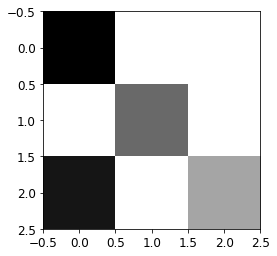

In [10]:
test_digit = np.array( [255,0,0,0,150,0,234 ,0,90])
test_image = test_digit.reshape(3,3)
print(test_image)
plt.imshow(test_image, cmap = mpl.cm.binary,interpolation="nearest")

We now take a look at some of the digits in the data

Saving figure some_digit_plot


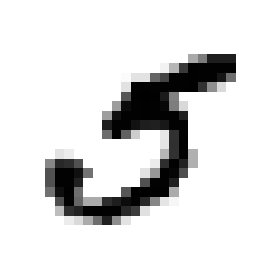

In [11]:
X, y = mnist["data"], mnist["target"]
#index = np.random.randint(0,70000)
index=36000
some_digit = X[index]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [12]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [13]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


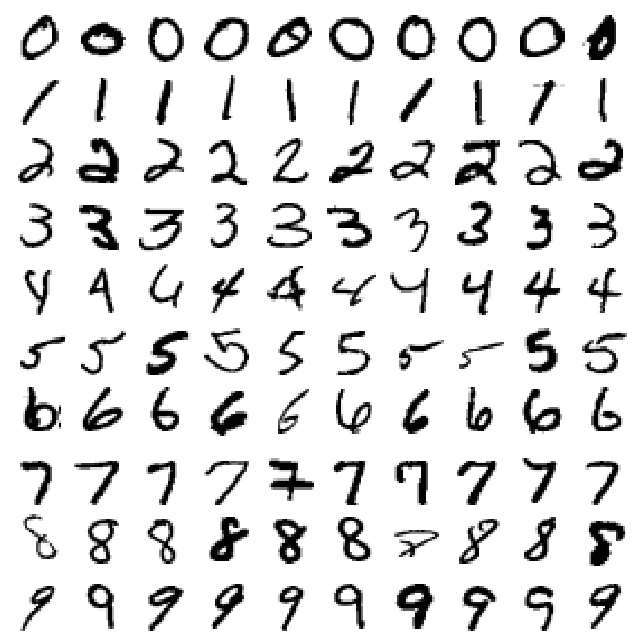

In [14]:
plt.figure(figsize=(9,9)) # 9 inches
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

In [15]:
np.r_?


In [16]:
y[36000]

5

# Training and test samples

- use first 60000 images for training 
- use the remaining 10000 for valdation and testing the algorithm 

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

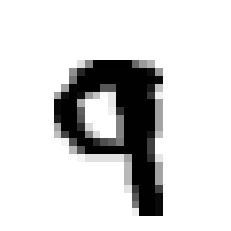

In [18]:
plot_digit(X_train[55000])

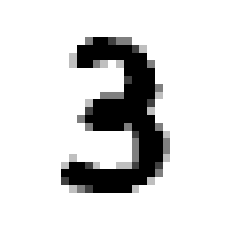

In [19]:
plot_digit(X_test[4000])

we first randomaise the training sample by generating randomaised index
 - this allows to have subsamples with random numbers
 - providing subsets witrgh just one digit are nor helpful for training
   - provide sets with both signal and background 
   

In [20]:
shuffle_index = np.random.permutation(6)
shuffle_index

array([0, 1, 5, 2, 4, 3])

In [21]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

here we generate a random set of indices and change __both__ data (X) and its target (y).

Reminder: data is a hand-written digit and target its true value

# Binary classifier

In this first example we do somethign simple. Rather than identifiying all digits we want to train a binary classifer to identify number __5__

- positive/success: digit is __5__
- negative/fail: digit is __NOT 5__

In this example we use a _Stochastic Gradient Descent (SGD)_ classifier, provided in [SciKit-Learn](https://scikit-learn.org/stable/). 

Some of the feature of this classifier are
- efficient handling of large samples
- relatively fast to find the minimum of the cost function

For more details on SGD see for example these webpages [1](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), [2](https://scikit-learn.org/stable/modules/sgd.html), [3](https://towardsdatascience.com/stochastic-gradient-descent-clearly-explained-53d239905d31)


The follwing boolean array will be used for training a classifier. They tell us which of the targets are actually a try hit (__5__).

In [22]:
y_train[:50]

array([9, 4, 8, 8, 1, 6, 0, 0, 6, 2, 8, 3, 2, 2, 6, 9, 1, 5, 6, 1, 8, 0,
       5, 8, 9, 9, 8, 4, 5, 2, 8, 2, 4, 6, 1, 0, 6, 4, 1, 7, 0, 2, 5, 9,
       4, 3, 3, 1, 5, 3], dtype=int8)

In [23]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [24]:
y_train_5[:50]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False])

Here we import the `SGDClassifier` class from Scikit-Learn

**Note**: a few hyperparameters will have a different default value in future versions of Scikit-Learn, so a warning is issued if you do not set them explicitly. This is why we set `max_iter=5` and `tol=-np.infty`, to get the same results as in the book, while avoiding the warnings.

In order to provide reproducibility of the results we set the random seed. You can change it to something else and see if it has any effects. 

In [25]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

- training is done with the `fit()` function
- we provide the `X_train` sample for training
- `y_train_5` is the boolean array telling the cliassifer the correct answer for each image. this is used by the algo to train and improve its performance

In [26]:
some_digit

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   

In [27]:
sgd_clf.predict([some_digit, X_train[2000], X_train[20]])

array([False,  True, False])

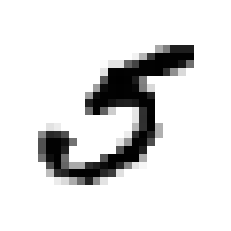

In [28]:
plot_digit(some_digit)

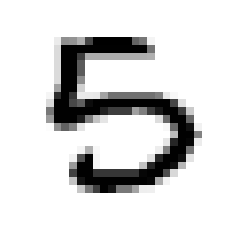

In [29]:
plot_digit(X_train[2000])

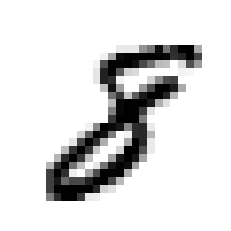

In [30]:
plot_digit(X_train[20])

# Measuring the performance of a classifier

A first natural perforemance measure could be the _accuracy_, rartio of correct predictions.

We do this using the so-called __cross-validation__ provided by scikit-learn
- divide the training sample is sub samples of K elements (k-folds), for example triplets. There are 20000 triplets in this case. 
- train the classifier on 19999 tripltes and then measure its accuracy on the remaining  triplet. 
- repeat this for each of the 20000 triplets

There is a simple function for all these steps!

In [31]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96595, 0.96405, 0.961  ])

So it seems that the classifier has a 95% accuracy! 

But let's now compare to a quite stupid classifier that classifies all images as __not 5__

In [32]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [33]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90805, 0.9081 , 0.9128 ])

So even this clearly-wrong classifer has 90% accuracy!

why ?

Remember that 
- 90% of all images are __Not 5__
- 10% of them are a __5__

So by assigning __not 5__ to all images you can 90% of them right, which the above accuracy.

So the conclusion is that _accuracy_ is not a good measure specially if the training sample is skewed as in this case

# Confusion Matrix

You should be already familiar with this concept from the statistics courses.

We have two classes of data: 
- class A or Signal
- class B or Background

and we define

- true positive (TP): signal classified as signal
- false positive (FP): background classified as signal
- false negative (FN): signal classified as background
- true negative (TN): background classified as background

These numbers compose what we call the __Confusion Matrix__. There is a function providing these numbers for the classifier

In [34]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

we first use the `cross_val_predict()` function and feed it with the training data and the correct answers (target).

This function performs k-fold validation , but instead of returning a score, it returns the precition as True or False for each test k-fold. 

Note that the fold being used for prediction was __not__ used for training. 

Then we compute the matrix

In [35]:
print(y_train_5[:20])
print(y_train_pred[:20])

[False False False False False False False False False False False False
 False False False False False  True False False]
[False False False False False False False False False False False False
 False False False False False  True False False]


In [36]:
from sklearn.metrics import confusion_matrix

cm_pred  = confusion_matrix(y_train_5, y_train_pred)
cm_pred

array([[53786,   793],
       [ 1387,  4034]])

Each row is the actual (true) class
- first row: true __Not 5__
- second row: true __5__

Each column is the predicted class
- first column: predicted __Not 5__
- second column: predicted __5__

the non-diagonal terms indicate the _false negative_ (signal classified as background) and _false positive_ (background classified as signal)

for a perfect classifier you would only have the diagonal terms

In [37]:
y_train_perfect_predictions = y_train_5

In [38]:
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

# Precision and Recall

In practice, ofetn other metrics are used to judge the goodness of the classifier for the purpose it was trained

__Precision__ is defined as the ratio __TP / (TP + FP)__
It tells use which fraction of the positives are true. So it is the _accuracy_ of the classifier

In [41]:
4498 / (4498 + 1604)

0.7371353654539495

and of course there is function to compute it

In [42]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.835715765485809

Similarly, __Recall__ is defined as the ratio __TP / (TP + FN)__

It tells use which fraction of true positives are classified correctly. So it is also called the __True Positive Rate__ (TPR) and often referred to also as _sensitivity_

In [43]:
4498 / (4498 + 923)

0.829736211031175

which can also be obtained by calling a function

In [44]:
recall_score(y_train_5, y_train_pred)

0.7441431470208448

# Tradeoff between Precision and Recall

So after all our classifier is not so great: it has a precision of 84%, so out of the selected __5__'s, 84% of them are true. And it only detects ~70% of the __5__'s. 

Which is more important? higher precision or higher recall ?

The answer depends on the problem we want to solve.

In particle physics precision is often called  __purity__ and recall is called __efficiency__.

When doing b-quark flavor tagginng of jets you want to achieve good purity without loosing too much efficiency. 

Similar arguments apply to a trigger decision
- a trigger decision is used to store or throw away each of the collision events at a Collider
- you define an algorithm or a set of selection criteria to select events with a good chance of contaiing an event of interest, e.g. a Higgs boson
- you want high efficiency: out of 1000 true signal events you would like to retain as manny as possible
- you also want high purity for the sample: out of 1000 stored events, you want the fraction of signal events to be as large as possibile

Balancing these two requests is your task. Let's see an example with our `SGDClassifier`

### Performance curve for `SGDClassifier`

The decision making process for the  `SGDClassifier` is the following
1. compute a score for a data point (an image) using a __decision function__
1. score >= threshold:  data point assigned to positive class/signal/class A/True
1. score < threshold: data point assigned to negative class/background/class B/False
 
 The  __threshold__ is the key parameter to balance precision and recall
 1. high threshold: high precision(purity) but low recall (efficiency)
 1. low threshold: high recall (efficinecy) but low precision (purity)
 
 
 
 You cannot fix  the threshold with scikit-learn but you can do the following to study the performance and select your preferred __working point__ for the classifier
1. use the `decision_function()` instead of `predict()`
  - no binary decision but rather a numerical value
1. vary the threshold between a  minimum and a maximum
1. study precision and recall as a functio of threshold 
1. find the threshold value provisding the  (precision,recall) pair fitting your needs
1. use this thereshold for decision making



Let's compute the score for `some_digit`

In [45]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-22089.78780677])

In [47]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [48]:
y_some_digit_pred

array([False])

By default, the `SGDClassifier` uses threshold=0. So we are simply reproducing the behavior of the `predict()` function for the classifier.

However, since we now have access to the decision score, we can change the threshold and see how it affects the classifier prediction and its performance

In [49]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

as exxpected, for a high threshold the recall goes down our `some_digit` is not selected.

In order to choose the best threshold for our needs we do the following
1. compute the `decision_function()` for all instances in the trainning set
1. vary the threshold from a minimum to a maximum value
  1. for each threshold, compute precision and recall
  1. plot precision and recall as a function of the threshold
1. select the appropriate working point

This can be done easily in scikit-learn, again using the `cross_val_predict` and asking for the `decision_function` instead of the `prediction`

In [50]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [51]:
y_scores.shape

(60000,)

Instead of iterating over the thresholds, we use a function provided in scikit-learn.

In [52]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [53]:
type(precisions)

numpy.ndarray

In [54]:
thresholds.shape

(59710,)

In [55]:
precisions.shape

(59711,)

In [56]:
recalls.shape

(59711,)

In [57]:
thresholds[:10]

array([-1666460.75942738, -1665993.03772524, -1665574.93412477,
       -1664596.91137635, -1663468.53628025, -1663403.77111197,
       -1663118.13652702, -1661846.2509253 , -1661821.96092416,
       -1660994.95315765])

In [58]:
thresholds[-10:]

array([ 811048.05335447,  817390.423217  ,  837156.44195342,
        863552.92223266,  870529.32510034,  872802.67767628,
        889729.48958051,  907076.82036151,  921306.31334581,
       1041236.36274904])

Saving figure precision_recall_vs_threshold_plot


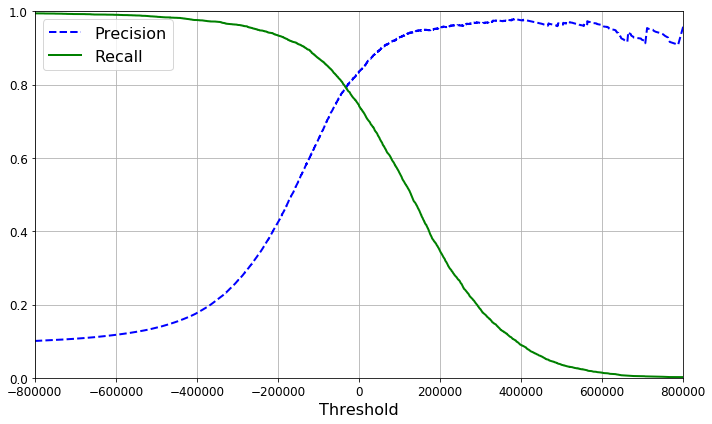

In [60]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.grid(all)

plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-800000, 800000])
save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [61]:
y_scores.max()

1041236.3627490397

In [62]:
y_scores.min()

-2833317.402523035

In [63]:
(y_train_pred == (y_scores > 0)).all()

True

# Working with customised threshold

Now suppose we want to have a classifier witgh 80% precision. We can zoom in to find the threshold

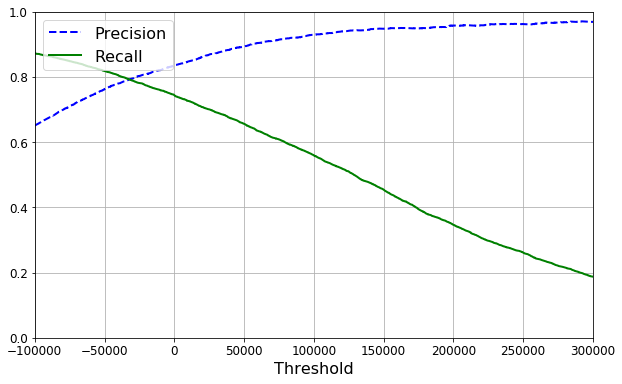

In [64]:
plt.figure(figsize=(10, 6))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-100000, 300000])
plt.show()

which appears to happen for a threshold of 100000. So we can build our custom precition with a precision of 80% 

In [65]:
y_train_pred_80 = (y_scores > 100000)

In [66]:
precision_score(y_train_5, y_train_pred_80)

0.9295558958652373

In [67]:
recall_score(y_train_5, y_train_pred_80)

0.559859804464121

# Precision vs. recall 

It is often popular and useful to report the same information in a different plot. Rather than findig the threshold we  emphasise the working point inn terms of precision and recall

Saving figure precision_vs_recall_plot


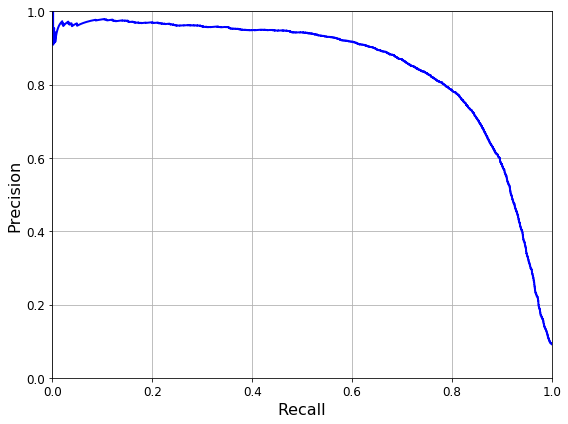

In [69]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(all)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("precision_vs_recall_plot")
plt.show()

# ROC curves

There are other commonly used plots showing the performance of a classification algorithm. 

One of the most popular ones is the _receiver operating characteristic_ (ROC) curve, which became popular during World War II in the analysis of the radar signals. See some details on [wikipedia](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)


The ROC curve shows the _True Positive Rate_ as a function of the _False Positive Rate_. The ideal classifiers has the highest possible TPR and FPR ~ 0.

All these quantities are easily computed in scikit-learn

In [70]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


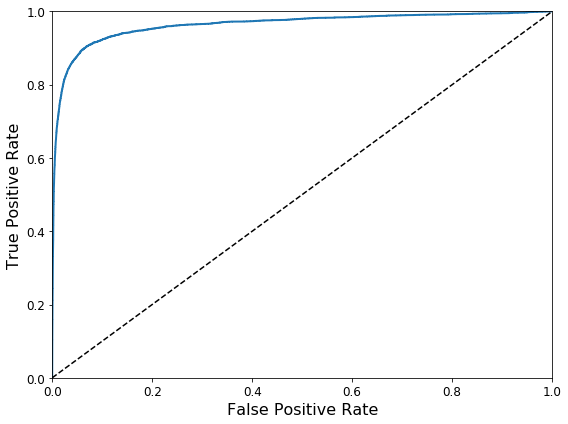

In [71]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
save_fig("roc_curve_plot")
plt.show()

The diagonal is the performance of a random classifier. 

Best classifiers are as close as possible to the top left corner.

The ROC curve provides a quantitative comparison between different classifiers. 

Rather than just looking at the ROC curve, one ca compue the _area under the curve_ (AUC). The classifier with the largest AUC has the best performace.

In [72]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9633427929064601

# _SGD_ vs _Random Forrest_

To see the AUC at work,  we use  `RandomForestClassifier` to compute the ROC curve and the AUC and compare to the `SGDClassifier`.

**Note**: we set `n_estimators=20` to avoid a warning about the fact that its default value will be set to 100 in Scikit-Learn 0.22.

In [75]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=20, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

There are some differences in using this new class
- `RandomForrestClassifier`  does not have a `decision_function()`. Instead it provides a predicted probablity function `predict_proba()`
  - all classifiers are requires to provide either `decision_function()` or `predict_proba()`
- `predict_proba()` returns an array of probabilities: one row for each instance (data point), one column for each class
  - column 0: probability of  __Not 5__
  - column 1: probability of being __5__
  
- to make the ROC curve we need a score for each instance
- we use the probaility of __being 5__ as the score to make the ROC curve

In [76]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Finally we plot both the `SGD` and the `Random Forrest` ROC curves

Saving figure roc_curve_comparison_plot


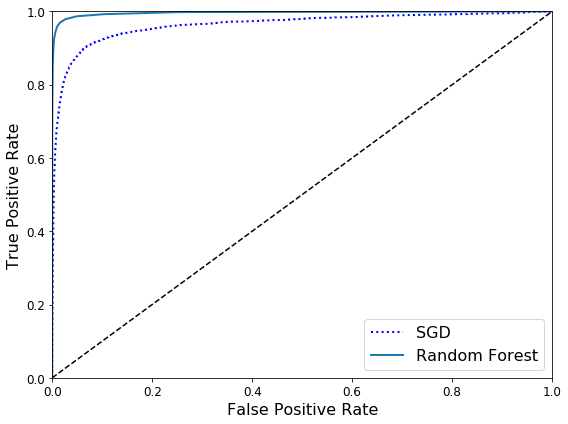

In [77]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [78]:
roc_auc_score(y_train_5, y_scores_forest)

0.9962534198695866

As expected `Random Forrest` has a might higher AUC! This is reflected also in the precision and recall values

In [79]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9873742777658892

In [80]:
recall_score(y_train_5, y_train_pred_forest)

0.8511344770337577

So now we have a precision (purity) of 99% and a recall (efficiency) of 86%.

This is to be compared to 80% (precision) and 72% (recall) for the `SGDClassifier`!

You might conclude that `Random Forrest` is __MUCH__ better than `SGD` ... 

... unfortunatly this is not correct.

The training sample has very few __5__'s (true positive) compared to __non 5__'s (true negative).

# Chossing between the ROC curve and the Precision/Recall (PR) plot

Typically PR plot is preferred __if__
- number of true positives (signal) is very small (e.g. rare signal)
- you care more about the false positives (fake signal) than false negative (efficiency loss)

otherwise use the ROC curve.

The PR plot for `Random Forest` is 

In [81]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

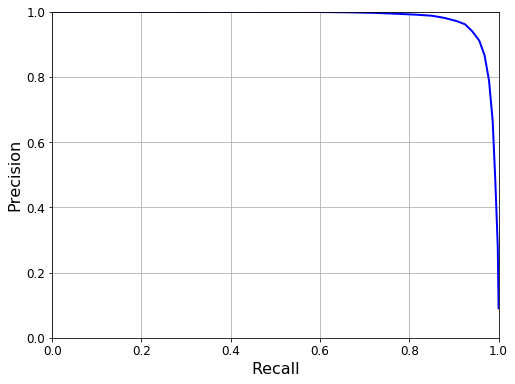

In [82]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions_forest, recalls_forest)

And since we have few __5__'s compared to __Non 5__'s we better compare the PR plots.

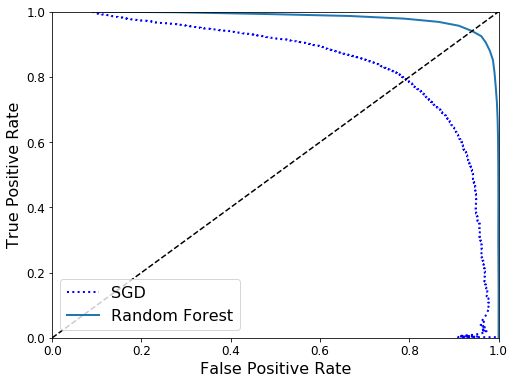

In [83]:
plt.figure(figsize=(8, 6))
plt.plot(precisions, recalls, "b:", linewidth=2, label="SGD")
plot_roc_curve(precisions_forest, recalls_forest, "Random Forest")
plt.legend(loc="lower left", fontsize=16)
plt.show()